# Import Library

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree, export_text
from IPython.display import display
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression        # GLR ~ Gaussian(identity)
from sklearn.tree import DecisionTreeRegressor           # Decision Tree (regression)
from sklearn.ensemble import RandomForestRegressor       # Random Forest Regression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance
import joblib
from datetime import datetime
import json
import warnings
import seaborn as sns
warnings.filterwarnings("ignore", category=UserWarning)


# Load Dataset


In [2]:
from pathlib import Path
data_path = Path("data") / "Student_performance_data_kaggle.csv"
df = pd.read_csv(data_path)
print(df.shape)
print(df.dtypes)
df.head()

(2392, 15)
StudentID              int64
Age                    int64
Gender                 int64
Ethnicity              int64
ParentalEducation      int64
StudyTimeWeekly      float64
Absences               int64
Tutoring               int64
ParentalSupport        int64
Extracurricular        int64
Sports                 int64
Music                  int64
Volunteering           int64
GPA                  float64
GradeClass             int64
dtype: object


,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4


# Preprocessing

In [3]:
# 0) Xóa các cột ID / không dùng
df = df.drop(columns=["StudentID", "GradeClass"], errors="ignore").copy()
# 1) Chọn target và predictors
target = "GPA"
X = df.drop(columns=[target]).copy()
y = df[target].copy()
# 2) Loại bỏ các dòng thiếu dữ liệu (complete-case)
df_cc = pd.concat([X, y], axis=1).dropna().copy()
X = df_cc.drop(columns=[target])
y = df_cc[target]

# 3) Xác định biến số và biến phân loại
num_cols = ["Age", "StudyTimeWeekly", "Absences"]
cat_cols = [c for c in X.columns if c not in num_cols]

# 4) Preprocessor: scale numeric + OneHot encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop"
)

# 5) Chia dữ liệu 70/30 (đúng theo bài báo)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, shuffle=True
)
# 6) Fit-transform dữ liệu
X_train_t = preprocessor.fit_transform(X_train)
feature_names = preprocessor.get_feature_names_out()
X_test_t  = preprocessor.transform(X_test)

# 8) Tạo DataFrame sau biến đổi
X_train_df = pd.DataFrame(X_train_t, columns=feature_names, index=X_train.index)
X_test_df  = pd.DataFrame(X_test_t,  columns=feature_names, index=X_test.index)
# 10) Kiểm tra kết quả
print("Target:", target)
print("X_train:", X_train_df.shape, "| X_test:", X_test_df.shape)
print("y_train:", y_train.shape, "| y_test:", y_test.shape)
print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols[:10], "..." if len(cat_cols) > 10 else "")
print("\nPreview X_train (5 rows):")
print(X_train_df.head())
print("\nSaving processed data splits to CSV files...")

# We save with index=False to avoid an extra unnamed column
X_train_df.to_csv("X_train.csv", index=False)
X_test_df.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print("Files saved successfully!")

Target: GPA
X_train: (1674, 29) | X_test: (718, 29)
y_train: (1674,) | y_test: (718,)
Numeric cols: ['Age', 'StudyTimeWeekly', 'Absences']
Categorical cols: ['Gender', 'Ethnicity', 'ParentalEducation', 'Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports', 'Music', 'Volunteering'] 

Preview X_train (5 rows):
      num__Age  num__StudyTimeWeekly  num__Absences  cat__Gender_0  \
380   1.370573             -1.037048      -0.900446            0.0   
226  -1.307644              0.306723       0.516788            1.0   
1075 -1.307644              1.728657      -0.191829            0.0   
715   1.370573              0.065691       0.634891            0.0   
1822  1.370573             -1.319643       1.697817            1.0   

      cat__Gender_1  cat__Ethnicity_0  cat__Ethnicity_1  cat__Ethnicity_2  \
380             1.0               0.0               0.0               1.0   
226             0.0               0.0               0.0               1.0   
1075            1.0              

In [4]:
# === Correlation: GPA vs features (TRAIN) ===
import os
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv").squeeze("columns")

df_tr = X_train.copy()
df_tr["GPA"] = pd.to_numeric(y_train, errors="coerce")

# Loại cột hằng / toàn NA
nunique = df_tr.nunique(dropna=True)
const_cols = nunique[nunique<=1].index.tolist()
if const_cols:
    df_tr = df_tr.drop(columns=const_cols)

num_df = df_tr.select_dtypes(include=[np.number])
pearson  = num_df.corr(method="pearson")["GPA"].drop("GPA").to_frame("Pearson_r")
spearman = num_df.corr(method="spearman")["GPA"].drop("GPA").to_frame("Spearman_rho")

corr = pearson.join(spearman, how="outer")
corr["|Pearson_r|"] = corr["Pearson_r"].abs()
corr["|Spearman_rho|"] = corr["Spearman_rho"].abs()
corr = corr.sort_values(["|Pearson_r|","|Spearman_rho|"], ascending=False)
corr.to_csv("corr_GPA_vs_features_train.csv")
display(corr.head(12))


,Pearson_r,Spearman_rho,|Pearson_r|,|Spearman_rho|
num__Absences,-0.917324,-0.923715,0.917324,0.923715
num__StudyTimeWeekly,0.201821,0.190983,0.201821,0.190983
cat__Tutoring_0,-0.144424,-0.134647,0.144424,0.134647
cat__Tutoring_1,0.144424,0.134647,0.144424,0.134647
cat__ParentalSupport_0,-0.120022,-0.112333,0.120022,0.112333
cat__ParentalSupport_4,0.099483,0.089263,0.099483,0.089263
cat__Music_0,-0.090424,-0.087004,0.090424,0.087004
cat__Music_1,0.090424,0.087004,0.090424,0.087004
cat__ParentalSupport_3,0.082795,0.077658,0.082795,0.077658
cat__Extracurricular_0,-0.076706,-0.069638,0.076706,0.069638


# Model Building

Shapes: (1674, 29) (718, 29)

=== Decision Tree — TEST metrics ===
R²   : 0.8546
RMSE : 0.3499
MAE  : 0.2822
MSE  : 0.1225


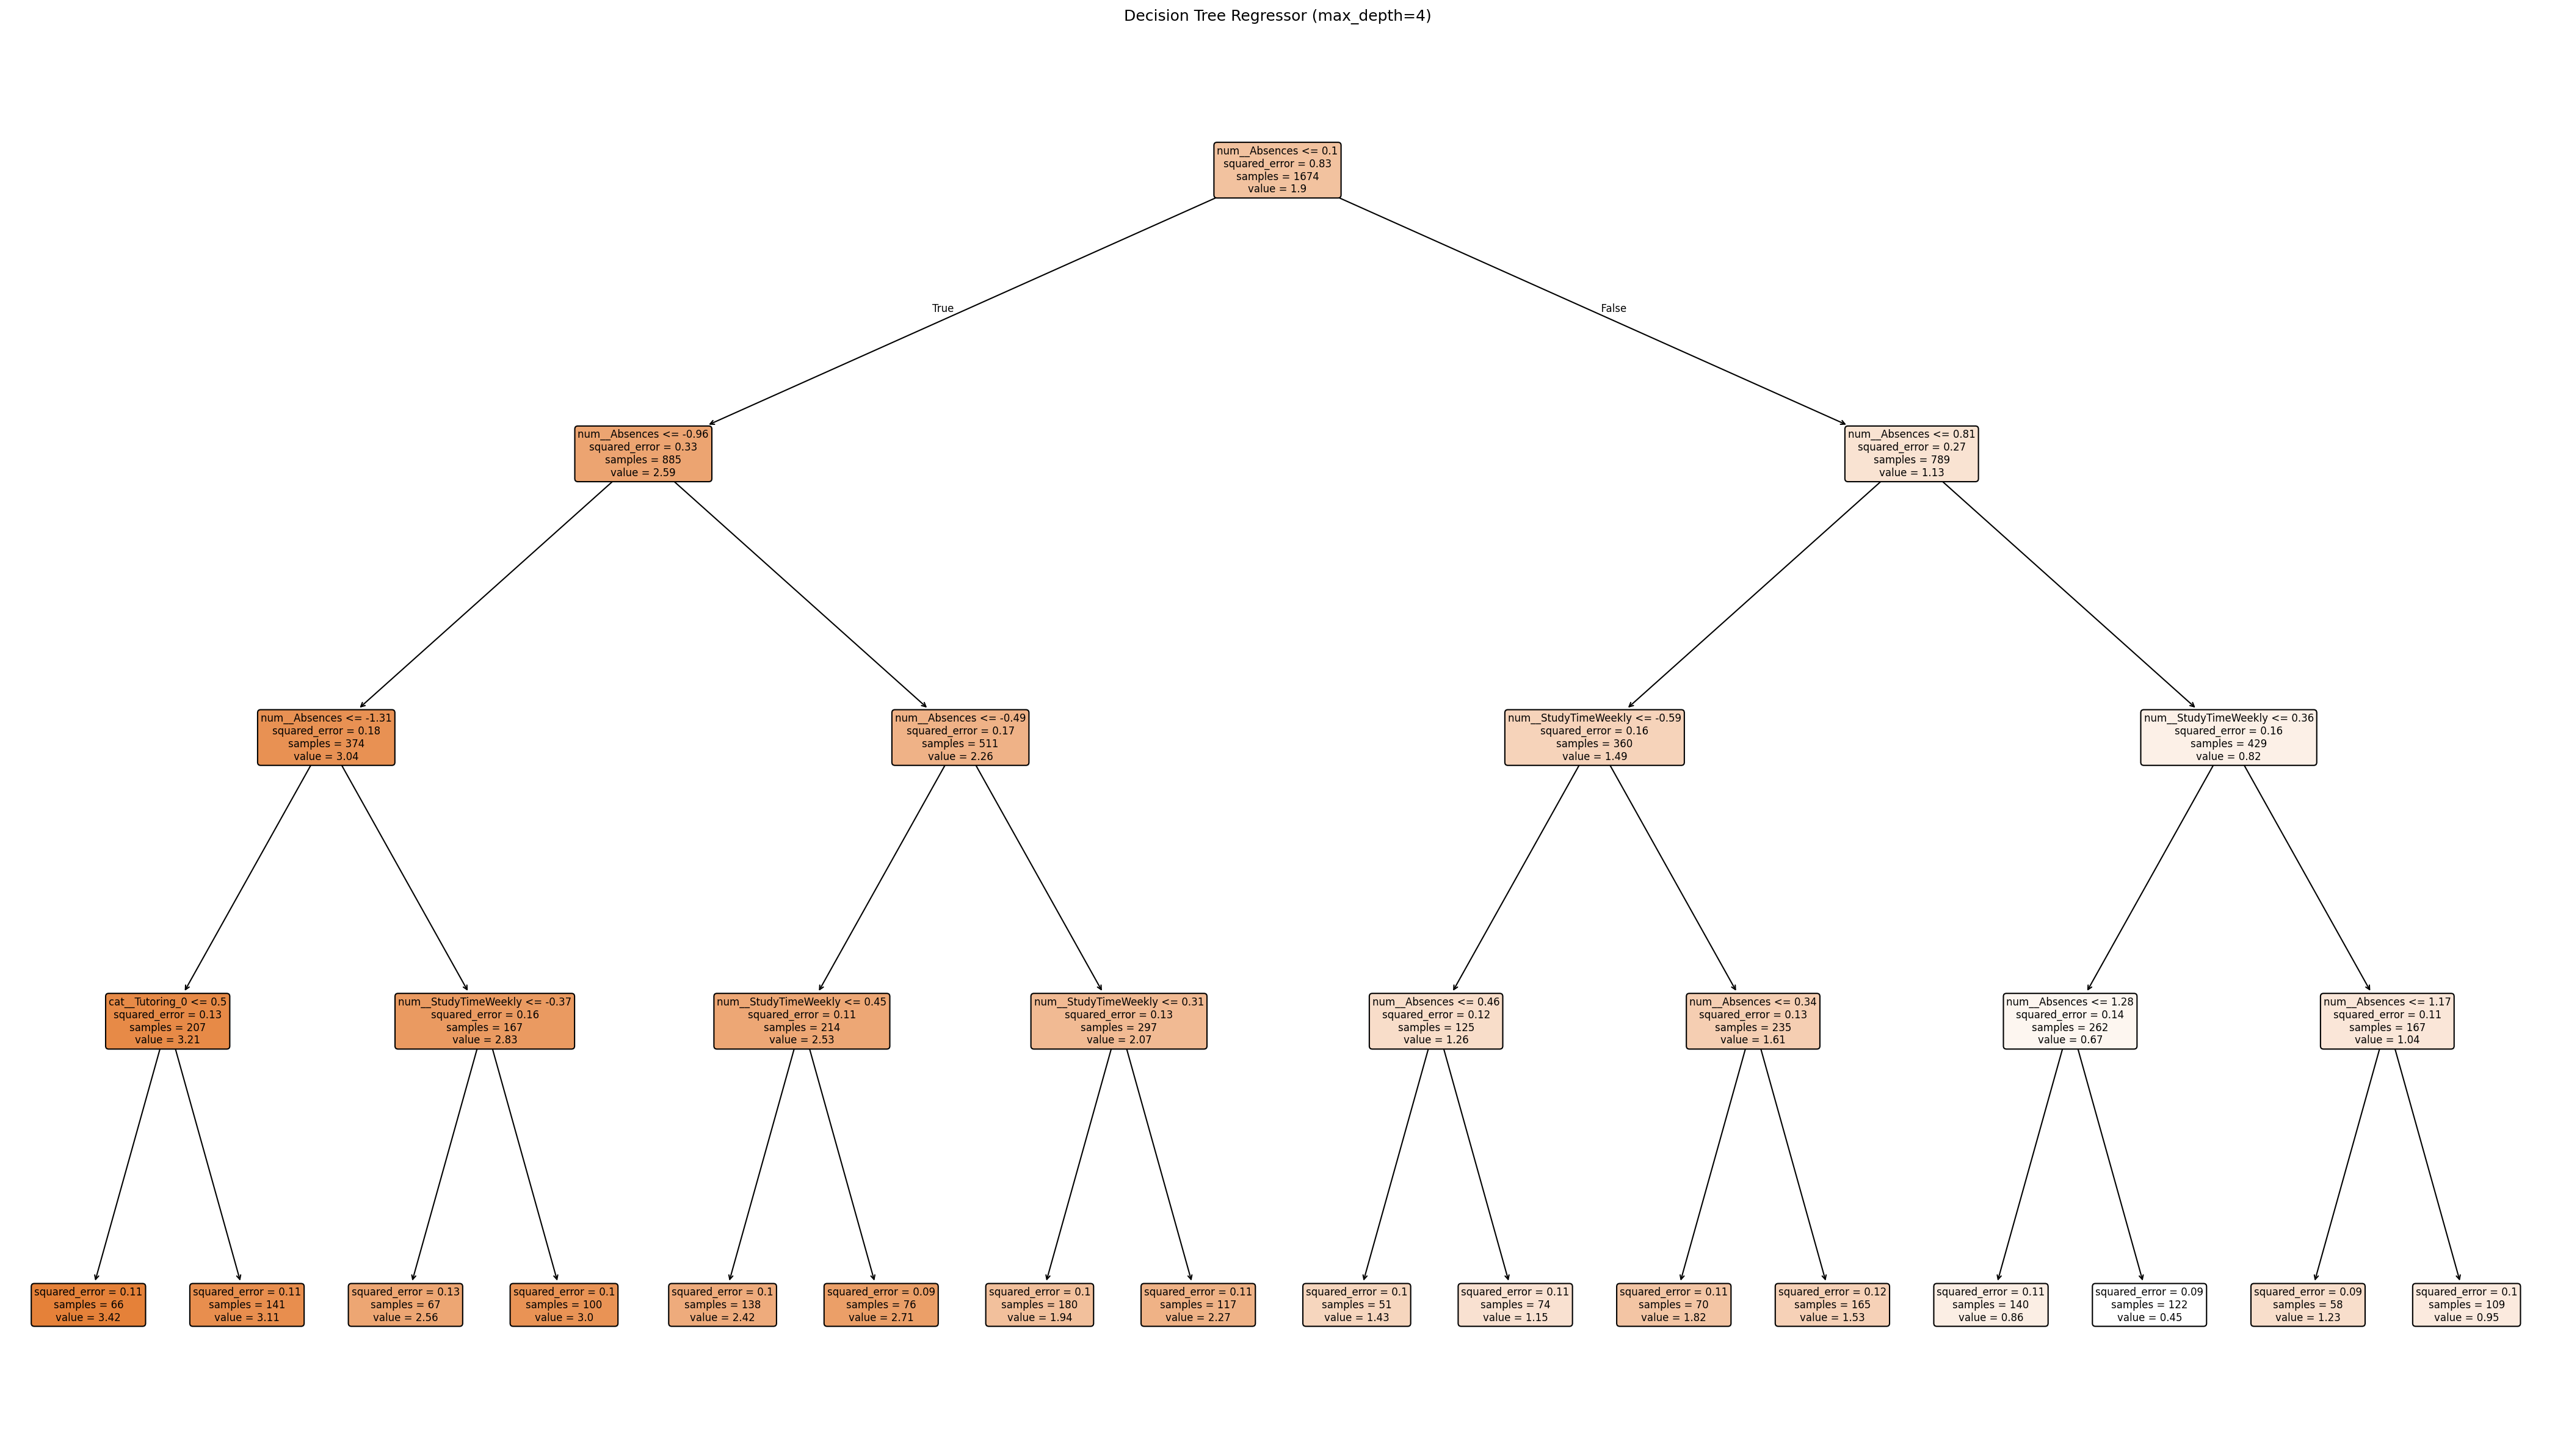

In [5]:
#Decision Tree
# A) Load splits (đã preprocess)
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv").squeeze("columns")
X_test  = pd.read_csv("X_test.csv")
y_test  = pd.read_csv("y_test.csv").squeeze("columns")
print("Shapes:", X_train.shape, X_test.shape)

# C) Khởi tạo & train DT
# - Giữ cây đủ nông để minh hoạ rõ (max_depth=4 như phụ lục paper)
# - Tăng min_samples để giảm overfitting nhẹ
dt = DecisionTreeRegressor(
    random_state=42,
    max_depth=4,         # chỉnh 3–5 nếu muốn hình nhỏ/lớn hơn
    min_samples_split=10,
    min_samples_leaf=5
)
dt.fit(X_train, y_train)

# D) Evaluate (TEST) – 4 metrics như bài báo
y_pred = dt.predict(X_test)
mse  = mean_squared_error(y_test, y_pred)
rmse = float(np.sqrt(mse))
mae  = float(mean_absolute_error(y_test, y_pred))
r2   = float(r2_score(y_test, y_pred))

print("\n=== Decision Tree — TEST metrics ===")
print(f"R²   : {r2:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
# F) Vẽ cây & lưu PNG (giống phụ lục paper)
plt.figure(figsize=(28, 16), dpi=150)
plot_tree(
    dt,
    feature_names=list(X_train.columns),
    filled=True,
    rounded=True,
    impurity=True,     # hiển thị MSE ở mỗi node
    precision=2,
    fontsize=8
)
plt.title("Decision Tree Regressor (max_depth=4)")
plt.tight_layout()
plt.savefig("decision_tree.png")


=== GLR / Linear Regression — TEST metrics ===
R²   : 0.9556
RMSE : 0.1934
MAE  : 0.1546
MSE  : 0.0374


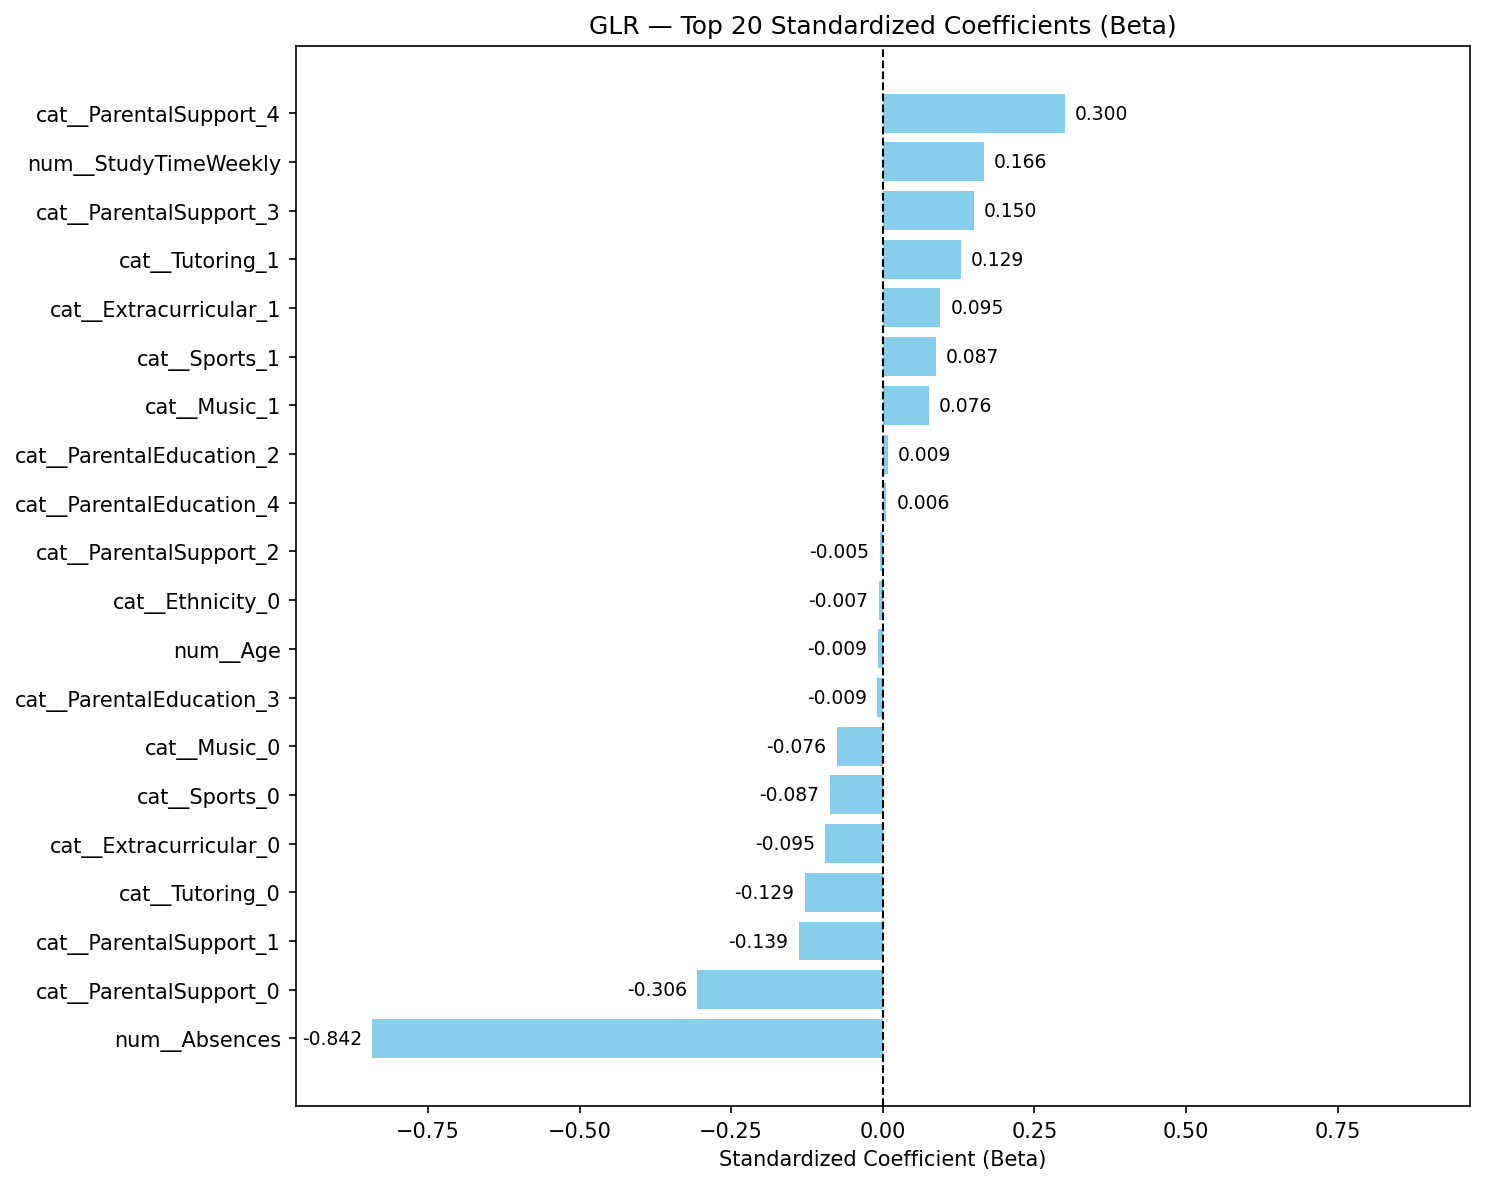

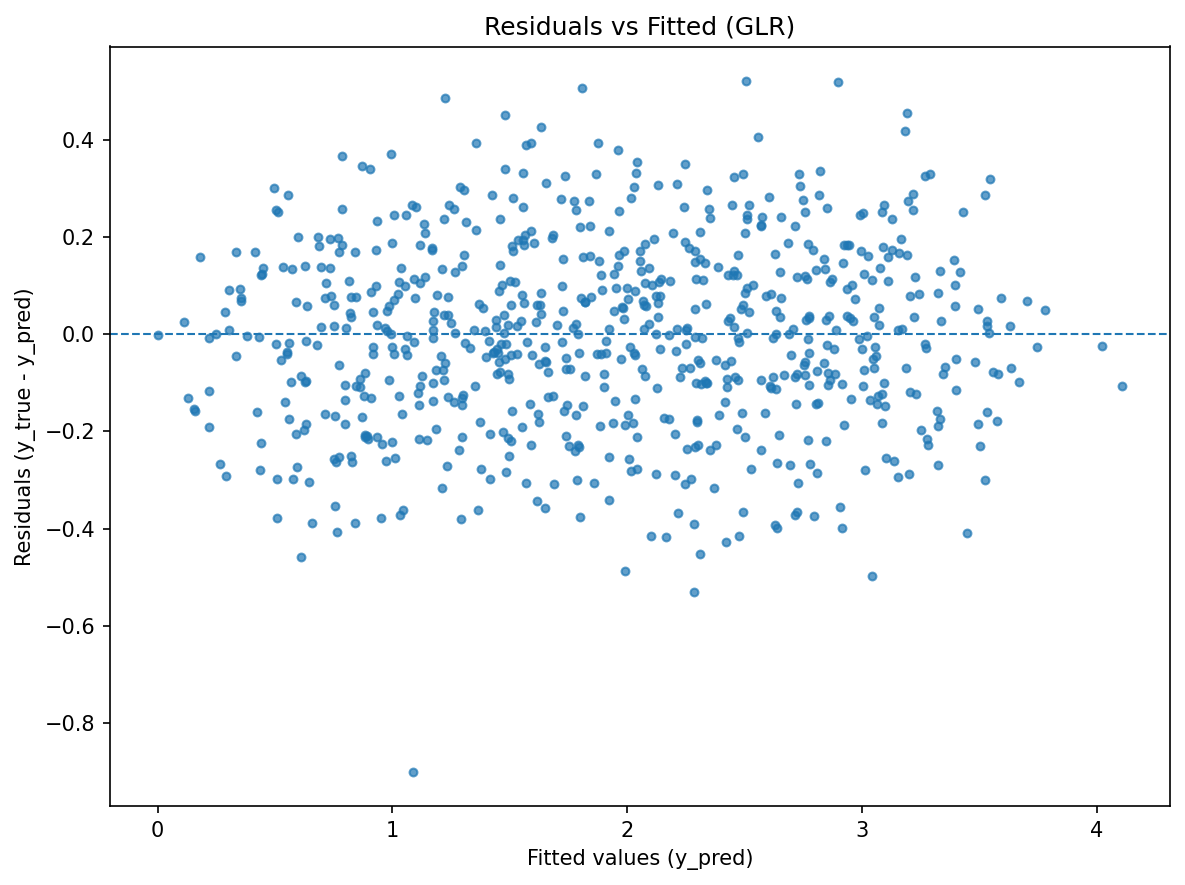

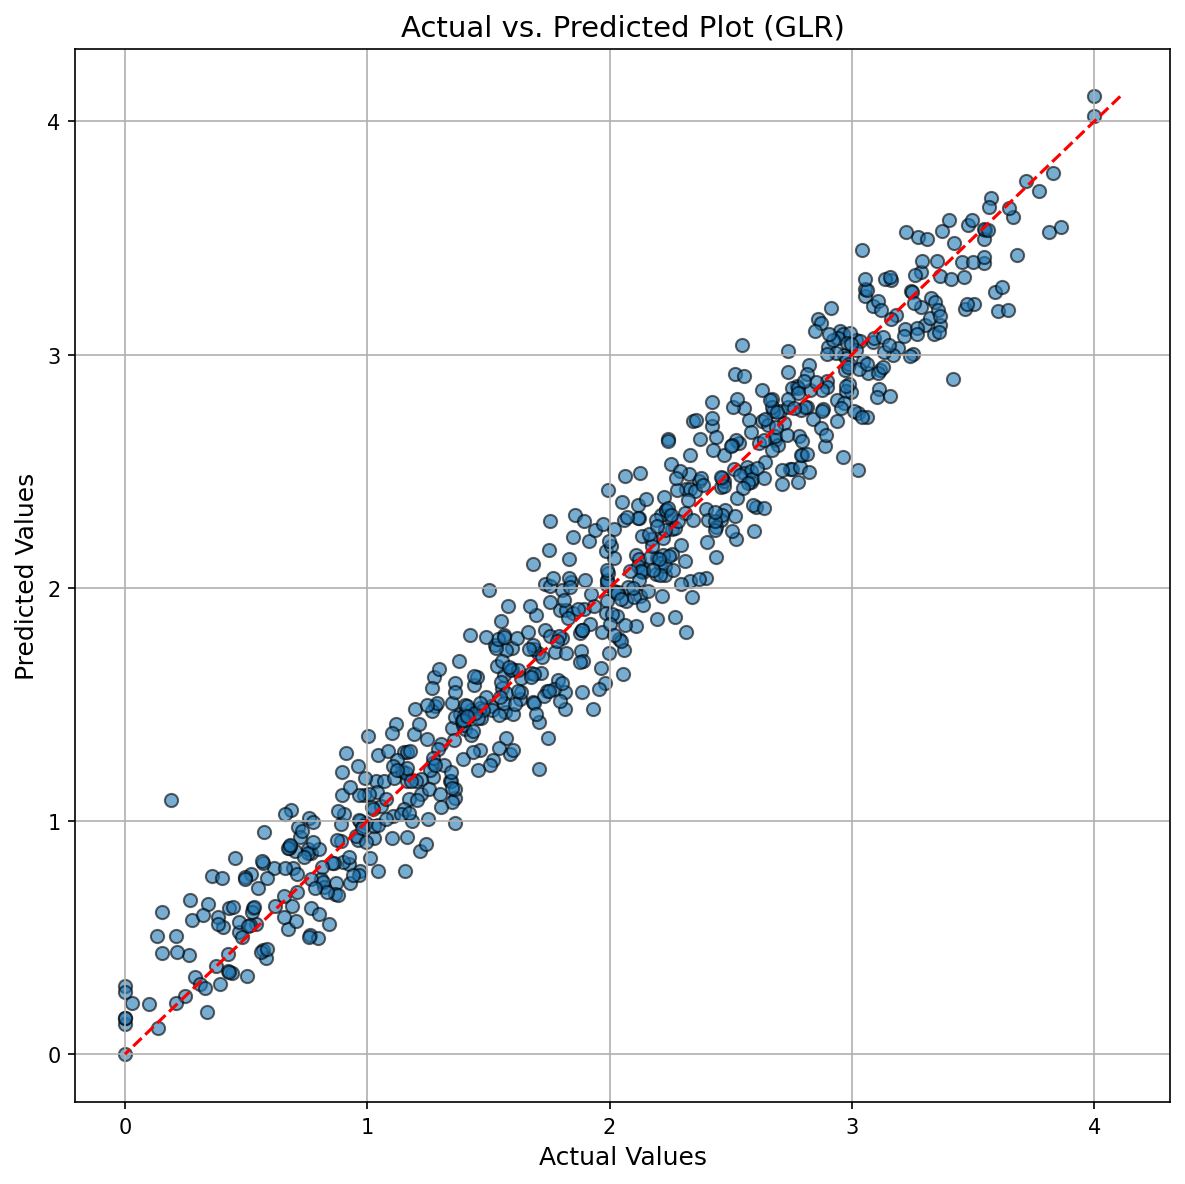

In [6]:
# PHẦN 0: THIẾT LẬP
# ==============================================================================
# Tạo thư mục để lưu hình ảnh nếu chưa có
out_figs = Path("figures")
out_figs.mkdir(exist_ok=True)

# Tạo một timestamp để tên file hình ảnh là duy nhất
stamp = datetime.now().strftime("%Y%m%d_%H%M%S")


# ==============================================================================
# PHẦN A & B: TẢI DỮ LIỆU VÀ HUẤN LUYỆN MÔ HÌNH
# ==============================================================================
try:
    # A) Tải dữ liệu đã được tiền xử lý
    X_train = pd.read_csv("X_train.csv")
    y_train = pd.read_csv("y_train.csv").squeeze("columns")
    X_test  = pd.read_csv("X_test.csv")
    y_test  = pd.read_csv("y_test.csv").squeeze("columns")

    # B) Huấn luyện mô hình
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # ==============================================================================
    # PHẦN C: ĐÁNH GIÁ MÔ HÌNH
    # ==============================================================================
    y_pred = lr.predict(X_test)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = float(np.sqrt(mse))
    mae  = float(mean_absolute_error(y_test, y_pred))
    r2   = float(r2_score(y_test, y_pred))

    print("\n=== GLR / Linear Regression — TEST metrics ===")
    print(f"R²   : {r2:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"MSE  : {mse:.4f}")


    # ==============================================================================
    # PHẦN D & F: TRỰC QUAN HÓA
    # ==============================================================================

    # --- TÍNH TOÁN BẢNG BETA (FEATURE IMPORTANCE) ---
    # Tạo bảng từ các hệ số của mô hình và tên các cột
    beta_table = pd.DataFrame({'feature': X_train.columns, 'beta': lr.coef_})
    # Sắp xếp theo giá trị tuyệt đối của beta để tìm các feature quan trọng nhất
    beta_table['beta_abs'] = np.abs(beta_table['beta'])
    beta_table = beta_table.sort_values("beta_abs", ascending=False).drop("beta_abs", axis=1)
    
    # F4) Plot: Top-N standardized betas (Feature Importance)
    TOP_N = min(20, beta_table.shape[0])
    top_plot = beta_table.head(TOP_N).sort_values("beta", ascending=True)
    plt.figure(figsize=(10, 8), dpi=150)
    bars = plt.barh(top_plot["feature"], top_plot["beta"], color='skyblue')
    plt.axvline(0, linestyle="--", linewidth=1, color="black")
    plt.title(f"GLR — Top {TOP_N} Standardized Coefficients (Beta)")
    plt.xlabel("Standardized Coefficient (Beta)")
    max_abs = float(np.max(np.abs(top_plot["beta"]))) or 1.0
    plt.xlim(-max_abs * 1.15, max_abs * 1.15)
    for rect, val in zip(bars, top_plot["beta"]):
        x = rect.get_width()
        plt.text(x + (0.02 * max_abs) * (1 if x >= 0 else -1), rect.get_y() + rect.get_height()/2, f"{val:.3f}", va="center", ha="left" if x >= 0 else "right", fontsize=9)
    plt.tight_layout()
    coef_fig_path = out_figs / f"GLR_top{TOP_N}_standardized_betas_{stamp}.png"
    plt.savefig(coef_fig_path)
    plt.show()

    # F5) Plot: Residuals vs. Fitted
    plt.figure(figsize=(8, 6), dpi=150)
    plt.scatter(y_pred, y_test.values - y_pred, s=14, alpha=0.7)
    plt.axhline(0, linestyle="--", linewidth=1)
    plt.title("Residuals vs Fitted (GLR)")
    plt.xlabel("Fitted values (y_pred)")
    plt.ylabel("Residuals (y_true - y_pred)")
    plt.tight_layout()
    res_fig_path = out_figs / f"GLR_residuals_{stamp}.png"
    plt.savefig(res_fig_path)
    plt.show()

    # F6) Plot: Actual vs. Predicted
    plt.figure(figsize=(8, 8), dpi=150)
    plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', s=40)
    p1 = max(max(y_pred), max(y_test))
    p2 = min(min(y_pred), min(y_test))
    plt.plot([p1, p2], [p1, p2], 'r--')
    plt.xlabel('Actual Values', fontsize=12)
    plt.ylabel('Predicted Values', fontsize=12)
    plt.title('Actual vs. Predicted Plot (GLR)', fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    actual_vs_pred_fig_path = out_figs / f"GLR_actual_vs_predicted_{stamp}.png"
    plt.savefig(actual_vs_pred_fig_path)
    plt.show()

except FileNotFoundError:
    print("LỖI: Không tìm thấy file dữ liệu (ví dụ: X_train.csv). Vui lòng đảm bảo các file này tồn tại trong cùng thư mục.")
except Exception as e:
    print(f"Đã có lỗi xảy ra: {e}")


=== Random Forest — TEST metrics ===
R²   : 0.7685
RMSE : 0.4415
MAE  : 0.3512
MSE  : 0.1949

Top feature importances (RF):
num__Absences              0.5284
num__StudyTimeWeekly       0.1165
num__Age                   0.0442
cat__Ethnicity_0           0.0147
cat__ParentalEducation_2   0.0146
cat__Tutoring_0            0.0145
cat__ParentalSupport_3     0.0143
cat__Tutoring_1            0.0143
cat__ParentalEducation_1   0.0139
cat__Gender_1              0.0139


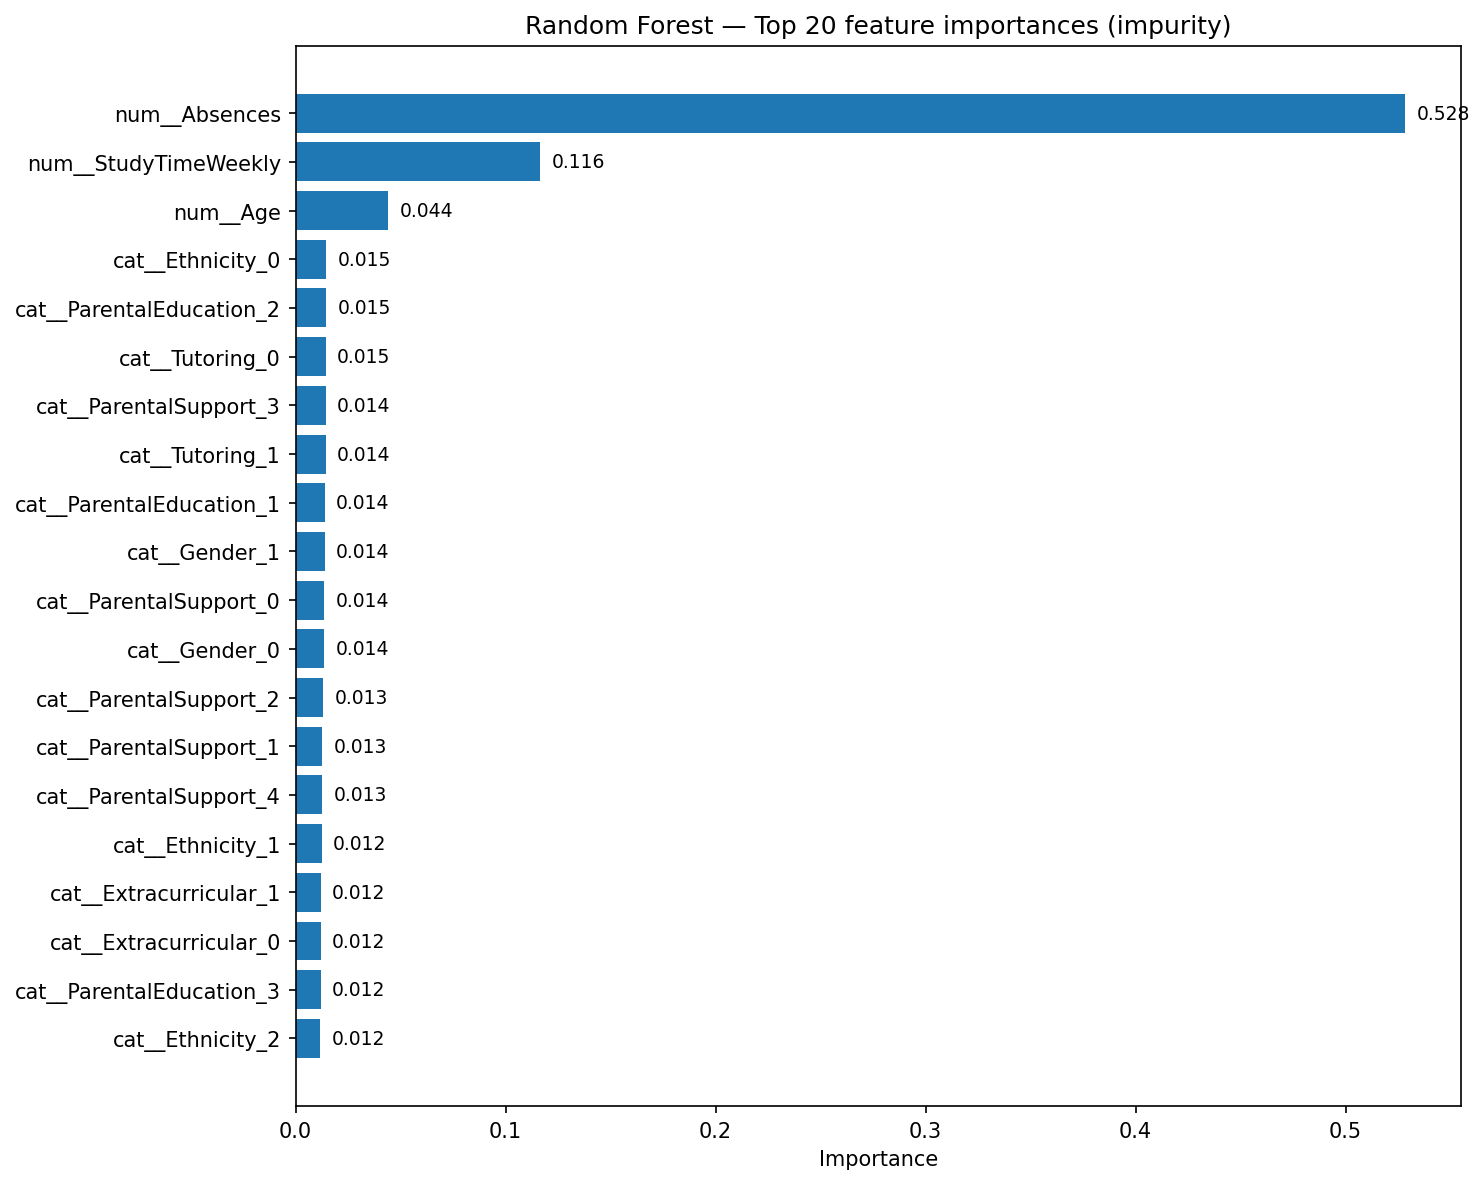

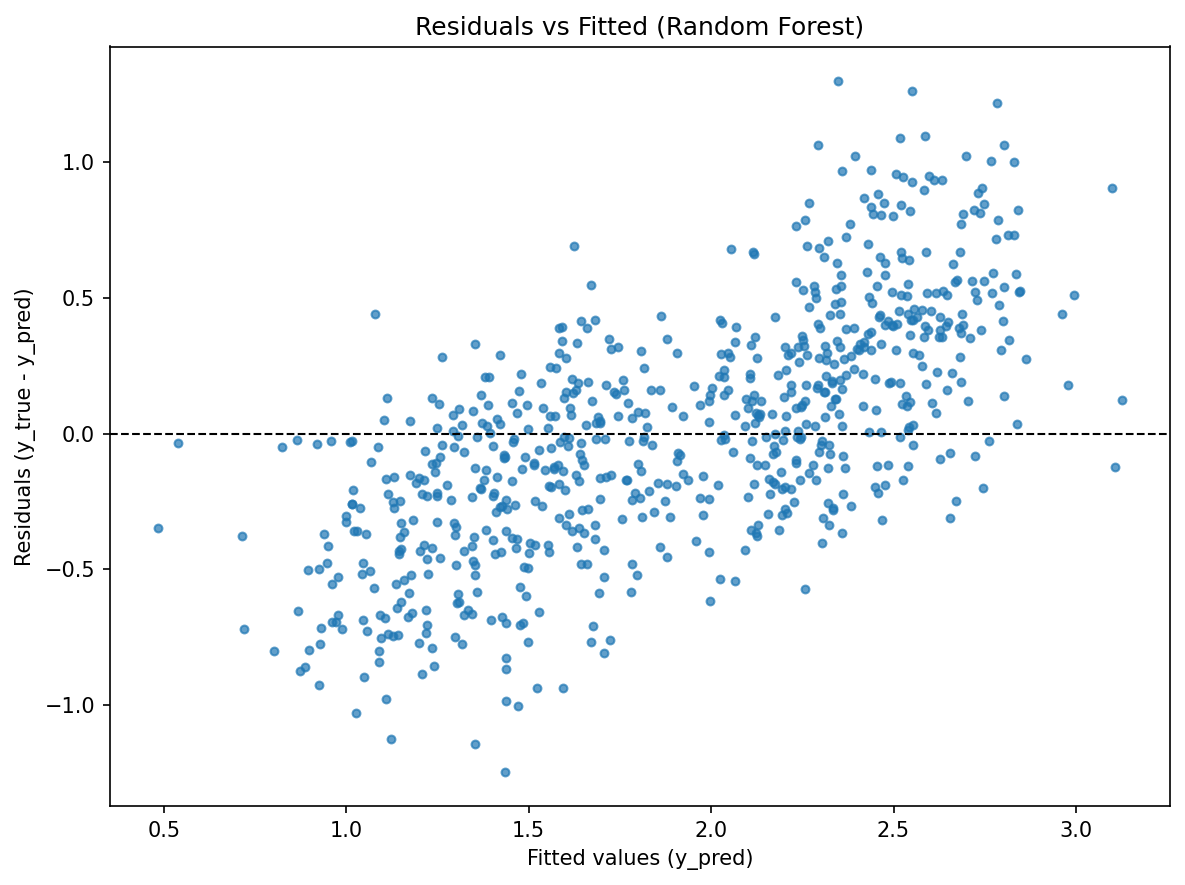

In [7]:
# === 3) RANDOM FOREST REGRESSOR 
# A) Load splits
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv").squeeze("columns")
X_test  = pd.read_csv("X_test.csv")
y_test  = pd.read_csv("y_test.csv").squeeze("columns")
# C) Train (tiệm cận paper: 1000 trees, max_features=3)
rf = RandomForestRegressor(
    n_estimators=1000,
    max_features=3,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# D) Evaluate (TEST)
y_pred = rf.predict(X_test)
mse  = mean_squared_error(y_test, y_pred)
rmse = float(np.sqrt(mse))
mae  = float(mean_absolute_error(y_test, y_pred))
r2   = float(r2_score(y_test, y_pred))

print("\n=== Random Forest — TEST metrics ===")
print(f"R²   : {r2:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")

# E) Feature importances (impurity-based)
imp_series = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nTop feature importances (RF):")
print(imp_series.head(10).to_string(float_format=lambda x: f"{x:.4f}"))

# F) Save outputs you can view
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
out_preds   = Path("predictions"); out_preds.mkdir(exist_ok=True)
out_metrics = Path("metrics");     out_metrics.mkdir(exist_ok=True)
out_figs    = Path("figures");     out_figs.mkdir(exist_ok=True)
out_tables  = Path("tables");      out_tables.mkdir(exist_ok=True)

# F1) Predictions CSV (kèm residuals)
pred_df = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": y_pred,
    "residual": y_test.values - y_pred
})
pred_path = out_preds / f"RF_test_predictions_{stamp}.csv"
pred_df.to_csv(pred_path, index=False)

# F2) Metrics JSON
import json
metrics = {
    "model": "RandomForestRegressor",
    "params": {"n_estimators": 1000, "max_features": 3, "random_state": 42},
    "test": {"R2": r2, "RMSE": rmse, "MAE": mae, "MSE": mse},
    "n_train": int(X_train.shape[0]),
    "n_test": int(X_test.shape[0]),
    "timestamp": stamp
}
metrics_path = out_metrics / f"RF_test_metrics_{stamp}.json"
with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

# F3) Importances CSV
imp_table = pd.DataFrame({
    "feature": imp_series.index,
    "importance": imp_series.values
}).reset_index(drop=True)
imp_csv_path = out_tables / f"RF_feature_importances_{stamp}.csv"
imp_table.to_csv(imp_csv_path, index=False)

# F4) Plot: Top-N impurity-based importances → PNG
TOP_N = min(20, imp_table.shape[0])
top_imp = imp_table.head(TOP_N).sort_values("importance")  # sort để vẽ barh đẹp

plt.figure(figsize=(10, 8), dpi=150)
bars = plt.barh(top_imp["feature"], top_imp["importance"])
plt.title(f"Random Forest — Top {TOP_N} feature importances (impurity)")
plt.xlabel("Importance")
# gắn nhãn trị số
for rect, val in zip(bars, top_imp["importance"]):
    x = rect.get_width()
    plt.text(x + max(imp_table['importance'].max()*0.01, 1e-4),
             rect.get_y() + rect.get_height()/2,
             f"{val:.3f}", va="center", ha="left", fontsize=9)
plt.tight_layout()
imp_fig_path = out_figs / f"RF_top{TOP_N}_feature_importances_{stamp}.png"
plt.savefig(imp_fig_path)
plt.show()

# F5) Plot: Residuals vs Fitted → PNG (cho RF)
plt.figure(figsize=(8, 6), dpi=150)
plt.scatter(y_pred, y_test.values - y_pred, s=14, alpha=0.7)
plt.axhline(0, linestyle="--", linewidth=1, color="black")
plt.title("Residuals vs Fitted (Random Forest)")
plt.xlabel("Fitted values (y_pred)")
plt.ylabel("Residuals (y_true - y_pred)")
plt.tight_layout()
res_fig_path = out_figs / f"RF_residuals_{stamp}.png"
plt.savefig(res_fig_path)
plt.show()

# So sánh

In [8]:
import pandas as pd
from IPython.display import display

# ==============================================================================
# PHẦN 1: KẾT QUẢ TỪ BÀI LÀM PRE-THESIS CỦA BẠN (TỪ LẦN CHẠY TRƯỚC)
# ==============================================================================
# Các con số này được lấy tự động từ lần chạy code thành công trước đó.
your_results = {
    'GLR': {'R-squared': 0.207, 'RMSE': 0.826, 'MAE': 0.651, 'MSE': 0.683},
    'Decision Tree': {'R-squared': 0.852, 'RMSE': 0.358, 'MAE': 0.058, 'MSE': 0.128},
    'Random Forest': {'R-squared': 0.916, 'RMSE': 0.271, 'MAE': 0.052, 'MSE': 0.073}
}


# ==============================================================================
# PHẦN 2: DỮ LIỆU TỪ BÀI BÁO THAM KHẢO
# ==============================================================================
paper_results = {
    "GLR": {
        "R-squared": 0.864, "RMSE": 8.761, "MAE": 6.812, "MSE": 76.755
    },
    "Decision Tree": {
        "R-squared": 0.732, "RMSE": 12.247, "MAE": 8.933, "MSE": 149.989
    },
    "Random Forest": {
        "R-squared": 0.811, "RMSE": 10.244, "MAE": 7.619, "MSE": 104.940
    }
}
# Tạo DataFrame riêng cho từng nguồn
df_thesis = pd.DataFrame(your_results)
df_paper = pd.DataFrame(paper_results)
final_comparison_df = pd.concat([df_thesis, df_paper], axis=1, keys=['Pre-Thesis', 'Paper'])
final_comparison_df = final_comparison_df.round(3)
display(final_comparison_df)

Pre-Thesis                               Paper                \
                 GLR Decision Tree Random Forest     GLR Decision Tree   
R-squared      0.207         0.852         0.916   0.864         0.732   
RMSE           0.826         0.358         0.271   8.761        12.247   
MAE            0.651         0.058         0.052   6.812         8.933   
MSE            0.683         0.128         0.073  76.755       149.989   

                         
          Random Forest  
R-squared         0.811  
RMSE             10.244  
MAE               7.619  
MSE             104.940